In [29]:
import matplotlib.pyplot as plt
import os
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.nn.functional import sigmoid

base_path = "./../Dataset/cifake"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

In [30]:
# convert to tensors and normalise pixel values to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

image, label = train_dataset[0] 
print(f"Dataset Shape: {train_dataset.__len__()}")
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")  # (batch, channel, height, width)
print(f"Batch label shape: {labels.shape}")  # (batch,)
print(f"Labels: {labels}")

print(f"Class-to-Label Mapping: {train_dataset.class_to_idx}")

Dataset Shape: 100000
Image shape: torch.Size([3, 32, 32])
Label: 0
Batch image shape: torch.Size([64, 3, 32, 32])
Batch label shape: torch.Size([64])
Labels: tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0])
Class-to-Label Mapping: {'FAKE': 0, 'REAL': 1}


In [31]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1,
                               padding=1)  # Input: (3, 32, 32) Output: (32, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,
                               padding=1)  # Input: (32, 32, 32) Output: (64, 32, 32)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,
                               padding=1)  # Input: (64, 32, 32) Output: (128, 32, 32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # dimension / 2

        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=512)  # flatten output from pool
        self.fc2 = nn.Linear(in_features=512, out_features=1)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Output: (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (64, 16, 16)
        x = self.pool(F.relu(self.conv3(x)))  # Output: (128, 8, 8)

        x = x.view(-1, 128 * 8 * 8)  # flatten to (batch_size, 128 * 8 * 8)

        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)  # no need for activation, BCELossWithLogits combines sigmoid

        return x

In [32]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

mps


In [33]:
trained_model = CNNModel()

Shows misclassified images

In [56]:
def show_predictions(images, labels, predictions, num_to_display=10):
    # Identify misclassified indices
    misclassified_idx = [i for i, (label, pred) in enumerate(zip(labels, predictions)) if label != pred]
    
    misclassified_idx = misclassified_idx[:num_to_display]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_idx):
        plt.subplot(1, num_to_display, i + 1)
        img = images[idx].permute(1, 2, 0)
        img = img.cpu().numpy()
        img = img / 2 + 0.5  
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {labels[idx]}\nPred: {predictions[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [73]:
def accuracy(test_loader, model, device):
    model.to(device)

    model.eval()
    pred_list = []
    true_list = []
    
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for i, data in enumerate(iter(test_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)
            probs = sigmoid(outputs) # apply sigmoid to convert outputs to range [0, 1]

            preds = (probs >= 0.5).long()
            corrects = preds == labels
            pred_list.append(preds.cpu().numpy())
            true_list.append(labels.cpu().numpy())
            
            total_correct += corrects.sum().item() # extracts the total correct value as a scalar value of a python number 
            total_samples += labels.size(0)
            if i == 100:
                print(f"Evaluation round {i}, misclassified images: ")
                show_predictions(inputs, labels ,preds, num_to_display=10)

    acc = total_correct / total_samples
    print(f"Accuracy: {100 * acc:>0.1f}%")
    return acc, pred_list, true_list

In [74]:
trained_model.load_state_dict(torch.load('mymodel_task2.pth', weights_only=True))
trained_model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Evaluation round 100, misclassified images: 


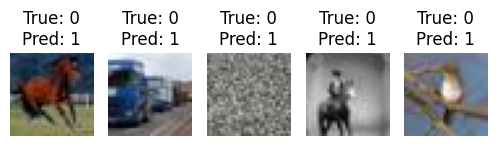

Accuracy: 94.0%


In [75]:
acc, predicted_labels, true_labels = accuracy(test_loader, trained_model, device)

Measures the proportion of correctly predicted instances out of the total instances.

In [76]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")


ValueError: unknown is not supported

Measures the proportion of positive identifications that were actually correct.

In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.2f}")

Measures the proportion of actual positives that were correctly identified.

In [ ]:
from sklearn.metrics import recall_score

recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f"Recall: {recall:.2f}")

Harmonic mean of precision and recall. It balances the two metrics.

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1:.2f}")

A table used to evaluate the performance of a classification model.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Real", "Fake"])
disp.plot(cmap='viridis')
plt.show()